In [27]:
## Load the data to get started
import pandas as pd
import numpy as np
import tensorflow as tf
import spacy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import keras

In [2]:
# !python -m spacy download en_core_web_md

In [4]:
nlp = spacy.load('en_core_web_md')

In [5]:
train = pd.read_csv("/content/train.csv" )

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer

stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')

# As this dataset is fetched from twitter so it has lots of people tag in tweets
# we will remove them 
tags = r"@\w*"


def preprocess_text(sentence, stem = True):
    sentence = tokenizer.tokenize(sentence)
    # sentence = sentence.split()

    # sentence = [re.sub(tags, "", sentence)]
    

    text = []
    # print(sentence)
    for word in sentence:
        word = word.lstrip()
        word = word.rstrip()
        word = word.replace(' ','')
        if word not in stopwords:
            
            if stem:
                text.append(stemmer.stem(word).lower())
            else:
                text.append(word.lower())
                
    return tokenizer.tokenize(" ".join(text))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
train.review = train.review .map(preprocess_text)
train.head()

,review,sentiment
0,"[aditya, ingol, deaf]",2
1,"[i, love, app, there, issu, u, could, add, fea...",1
2,"[so, hard, use, the, web, app, fail, mobil, ap...",0
3,"[i, hate, app, make, sound, everi, time, someo...",1
4,"[useless, bse, star, mf, meet, voic, mych, slo...",0


In [9]:
# vocabulary of words present in dataset
data_vocab = []
for text in train.review :
    for word in text:
        if word not in data_vocab:
            data_vocab.append(word)

In [10]:
len(data_vocab)

12785

In [11]:
train.review =train.review .apply(lambda x: " ".join(x) )

In [12]:
train.head(2)

,review,sentiment
0,aditya ingol deaf,2
1,i love app there issu u could add featur spotl...,1


In [14]:
max_fatures = len(data_vocab)
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train['review'].values)
X = tokenizer.texts_to_sequences(train['review'].values)
X = pad_sequences(X)

In [16]:
X

array([[   0,    0,    0, ..., 3641, 4376, 2354],
       [   0,    0,    0, ...,   84,   57,   20],
       [   0,    0,    0, ...,    1,  271,  144],
       ...,
       [   0,    0,    0, ...,    0,  120,  998],
       [   0,    0,    0, ...,   63,  218,  106],
       [   0,    0,    0, ...,  272,  818,    8]], dtype=int32)

In [21]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 271, 128)          1636480   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 271, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 64)                12608     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,904,083
Trainable params: 1,904,083
Non-trainable params: 0
____________________________________________

In [22]:
!pip install pydot graphviz

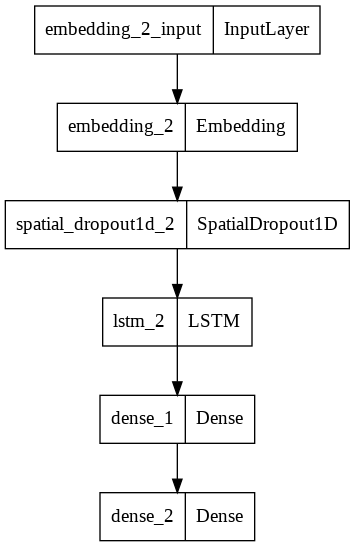

In [23]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [25]:
Y = pd.get_dummies(train['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(29172, 271) (29172, 3)
(7294, 271) (7294, 3)


In [29]:
# Creat checkpoint to save model at the end of each epoch:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

# Creat EarlyStopping checkpoint:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


history = model.fit(X_train, Y_train, epochs = 5 ,validation_split = 0.2 , callbacks=[checkpoint_cb, early_stopping_cb], batch_size = 64)

Epoch 1/5
365/365 [==============================] - 759s 2s/step - loss: 0.9297 - accuracy: 0.5515 - val_loss: 0.8262 - val_accuracy: 0.6187
Epoch 2/5
365/365 [==============================] - 746s 2s/step - loss: 0.7825 - accuracy: 0.6564 - val_loss: 0.7969 - val_accuracy: 0.6430
Epoch 3/5
365/365 [==============================] - 726s 2s/step - loss: 0.7041 - accuracy: 0.7005 - val_loss: 0.7870 - val_accuracy: 0.6533
Epoch 4/5
365/365 [==============================] - 730s 2s/step - loss: 0.6411 - accuracy: 0.7327 - val_loss: 0.7971 - val_accuracy: 0.6523
Epoch 5/5
365/365 [==============================] - 741s 2s/step - loss: 0.5933 - accuracy: 0.7509 - val_loss: 0.8230 - val_accuracy: 0.6596


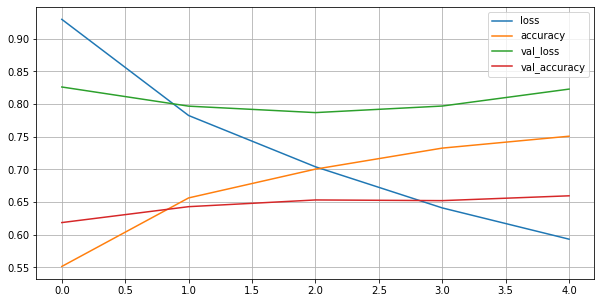

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

learning_data = pd.DataFrame(history.history)
# learning_data.head()
learning_data.plot(figsize=(10,5))
plt.grid(True)
plt.show()

In [47]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 64)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))


44/44 - 13s - loss: 0.8337 - accuracy: 0.6460 - 13s/epoch - 288ms/step
score: 0.83
acc: 0.65


Finally measuring the number of correct guesses. It is clear that finding negative reviews goes very well for the Network but deciding whether is positive is not really. My educated guess here is that the positive training set is dramatically smaller than the negative, hence the "bad" results for positive tweets.

In [34]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

1/1 - 0s - 391ms/epoch - 391ms/step
1/1 - 0s - 89ms/epoch - 89ms/step
1/1 - 0s - 91ms/epoch - 91ms/step
1/1 - 0s - 84ms/epoch - 84ms/step
1/1 - 0s - 86ms/epoch - 86ms/step
1/1 - 0s - 86ms/epoch - 86ms/step
1/1 - 0s - 94ms/epoch - 94ms/step
1/1 - 0s - 99ms/epoch - 99ms/step
1/1 - 0s - 90ms/epoch - 90ms/step
1/1 - 0s - 105ms/epoch - 105ms/step
1/1 - 0s - 97ms/epoch - 97ms/step
1/1 - 0s - 87ms/epoch - 87ms/step
1/1 - 0s - 85ms/epoch - 85ms/step
1/1 - 0s - 99ms/epoch - 99ms/step
1/1 - 0s - 104ms/epoch - 104ms/step
1/1 - 0s - 107ms/epoch - 107ms/step
1/1 - 0s - 93ms/epoch - 93ms/step
1/1 - 0s - 86ms/epoch - 86ms/step
1/1 - 0s - 87ms/epoch - 87ms/step
1/1 - 0s - 92ms/epoch - 92ms/step
1/1 - 0s - 92ms/epoch - 92ms/step
1/1 - 0s - 91ms/epoch - 91ms/step
1/1 - 0s - 87ms/epoch - 87ms/step
1/1 - 0s - 85ms/epoch - 85ms/step
1/1 - 0s - 90ms/epoch - 90ms/step
1/1 - 0s - 98ms/epoch - 98ms/step
1/1 - 0s - 99ms/epoch - 99ms/step
1/1 - 0s - 100ms/epoch - 100ms/step
1/1 - 0s - 90ms/epoch - 90ms/step
1/1 

In [35]:
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 62.08291203235592 %
neg_acc 68.4931506849315 %


In [48]:
from sklearn.metrics import classification_report, confusion_matrix

In [61]:
Y_pred = model.predict(X_test) 

In [62]:
classes_x = np.argmax(Y_pred,axis=1)

In [73]:
classes_x

array([0, 0, 1, ..., 1, 0, 1])

In [85]:
Y_pred

array([[0.35205165, 0.31121245, 0.3367358 ],
       [0.6731324 , 0.1816517 , 0.14521585],
       [0.39238957, 0.4999472 , 0.10766321],
       ...,
       [0.1410571 , 0.48044735, 0.3784955 ],
       [0.8496346 , 0.13917822, 0.01118715],
       [0.343183  , 0.4436546 , 0.21316236]], dtype=float32)

In [94]:
Y_test

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [96]:
import numpy as np
Y_test_labels=np.argmax(Y_test, axis=1)
Y_test_labels[1]

0

In [100]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(classes_x , Y_test_labels )
cm

array([[656, 191,  88],
       [171, 351, 120],
       [133, 288, 796]])

In [101]:
print(classification_report(Y_test_labels, classes_x))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       960
           1       0.55      0.42      0.48       830
           2       0.65      0.79      0.72      1004

    accuracy                           0.65      2794
   macro avg       0.63      0.63      0.63      2794
weighted avg       0.64      0.65      0.64      2794

